In [1]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch Version: ",torch.__version__)

Torch Version:  2.3.0


In [2]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
model,preprocess=clip.load("ViT-B/32")
model.cuda().eval()
input_resolution=model.visual.input_resolution
context_resolution=model.context_length
vocab_size=model.vocab_size


print("Model parameters: ",f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:",input_resolution)
print("Context length:", context_resolution)
print("Vocab size:",vocab_size)

Model parameters:  151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## Image Processing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, will normalize the pixel intensity using the dataset mean and standard deviation 

In [4]:
preprocess #seeing the transformation that are applied to image

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x798803bfa700>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text Processing

We use a case-insensitive tokenizer whcih can be invoked using clip.tokenize(). By defualt, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [5]:
tmp=clip.tokenize("Hello World!")  # BPE encoder
print(tmp.shape)


torch.Size([1, 77])


## Setting images and text

We are going to feed 8 example images and their textual description to the model, and compare the similarity between the correspoinding features. 

The tokenizer is case-insensitive, and we can freely give any suitable textual description

In [6]:
import os 
import skimage
import IPython.display
import matplotlib.pylab as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format='retina'


#image in skimage to use and their textual description
descriptions={
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo  of tobby cat",
    "astronaut": "a potrait of astronaut with American Flag",
    "rocket": "rocket standing on the launchpad",
    "motorcycle_right": "a red motorcycle standing in the garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer",
}

In [7]:
import skimage.data
skimage.data.download_all()

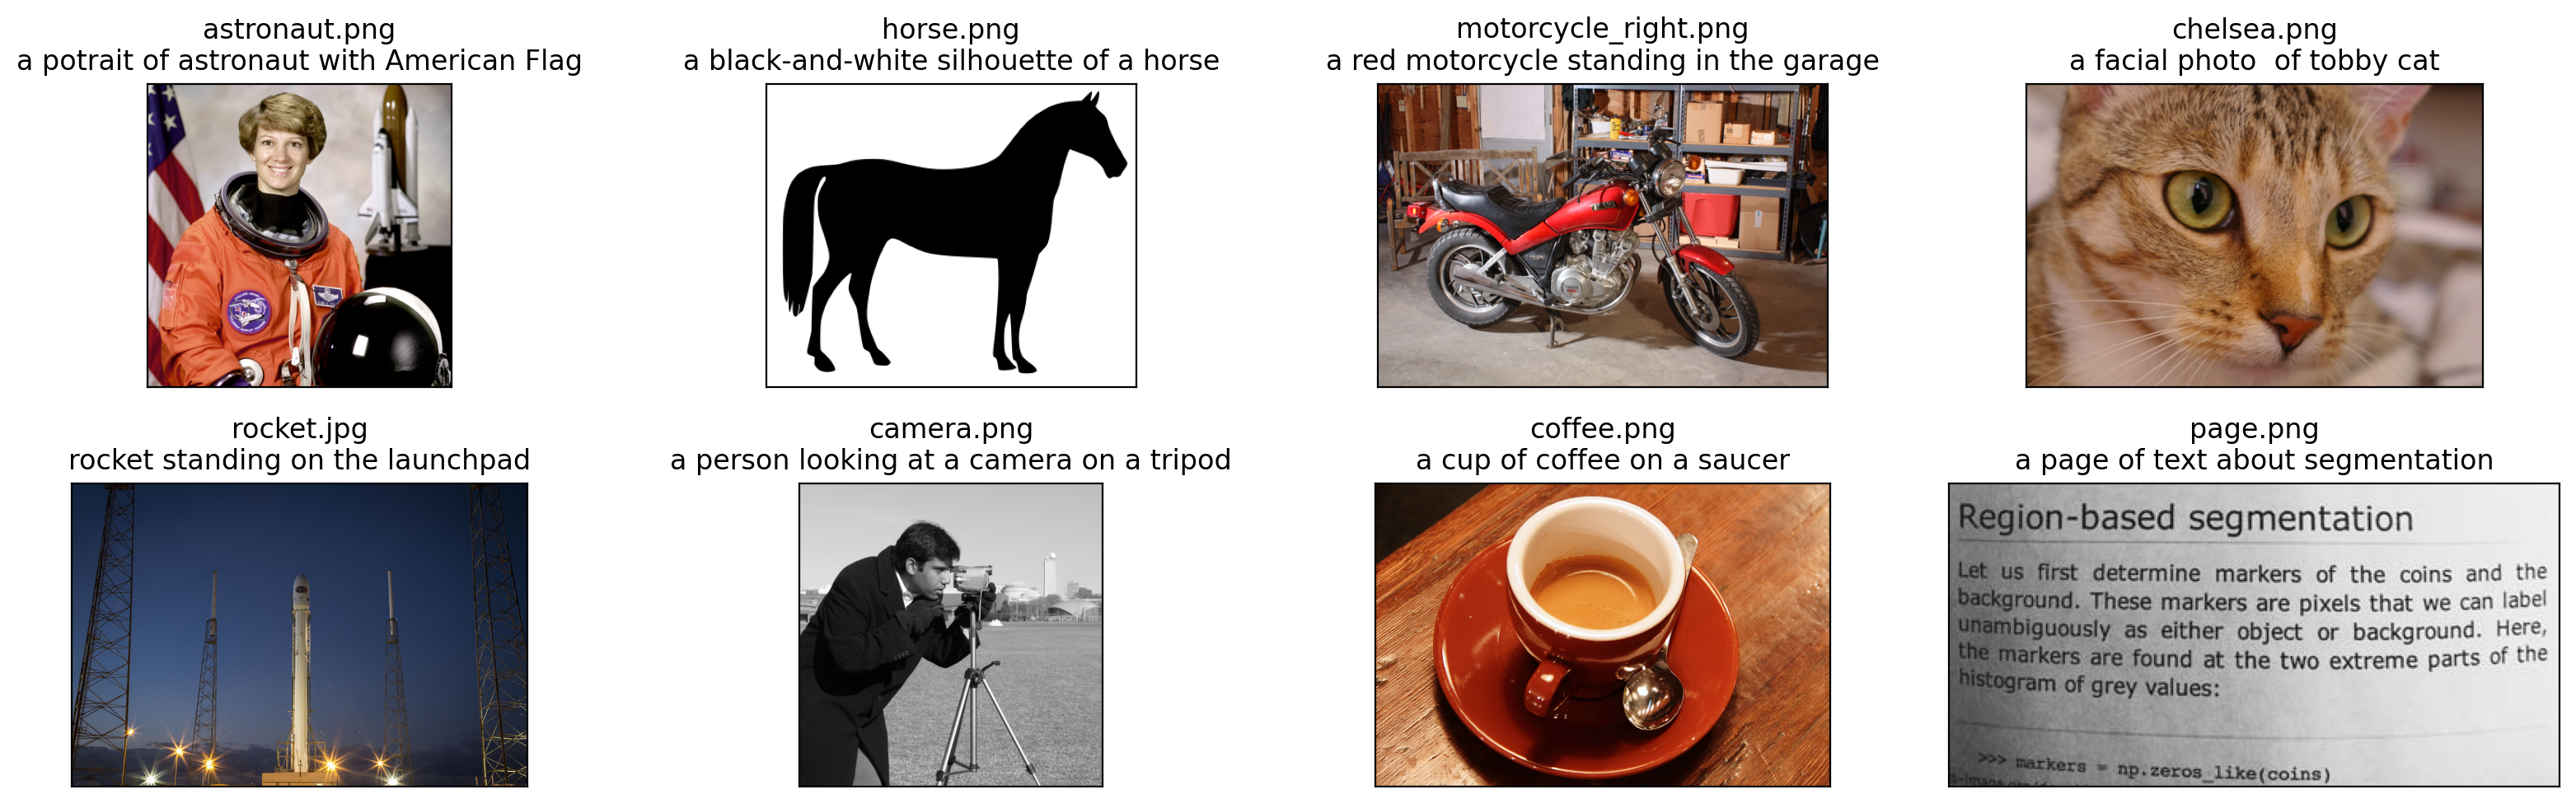

In [8]:
original_images=[]
images=[]
texts=[]
plt.figure(figsize=(16,5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name=os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image=Image.open(os.path.join(skimage.data_dir,filename)).convert('RGB')

    plt.subplot(2,4,len(images)+1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))  #applying th 
    texts.append(descriptions[name])


plt.tight_layout()

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features

In [9]:
image_input=torch.tensor(np.stack(images)).cuda()
text_token=clip.tokenize(["This is "+ desc for desc in texts]).cuda()

In [10]:
print(image_input.shape)
print(text_token.shape)

torch.Size([8, 3, 224, 224])
torch.Size([8, 77])


In [11]:
with torch.no_grad():
    # (8,512)
    image_features=model.encode_image(image_input).float()
    # (8,512)
    text_features=model.encode_text(text_token).float()


In [12]:
print(image_features.shape)
print(text_features.shape)

torch.Size([8, 512])
torch.Size([8, 512])


## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair

In [13]:
print(image_features.norm(dim=-1,keepdim=True))

tensor([[ 9.2550],
        [11.1000],
        [10.4230],
        [11.4355],
        [10.7126],
        [11.1888],
        [11.5223],
        [ 8.7287]], device='cuda:0')


In [14]:
image_features/=image_features.norm(dim=-1,keepdim=True)  #This means "compute the norm along the last dimension of the tensor"
# For example, if you have a tensor of shape (3, 4) and you use dim=-1, the norm will be computed along each row, since the last dimension (axis 1) has size 4.
#The keepdim=True ensures that the output tensor keeps the same number of dimensions as the original, but the second dimension (axis 1) is of size 1
text_features/=text_features.norm(dim=-1,keepdim=True)
similarity=text_features.cpu().numpy()@image_features.cpu().numpy().T

In [15]:
print(similarity.shape)


(8, 8)


Text(0.5, 1.0, 'Cosine similarity between text and image features')

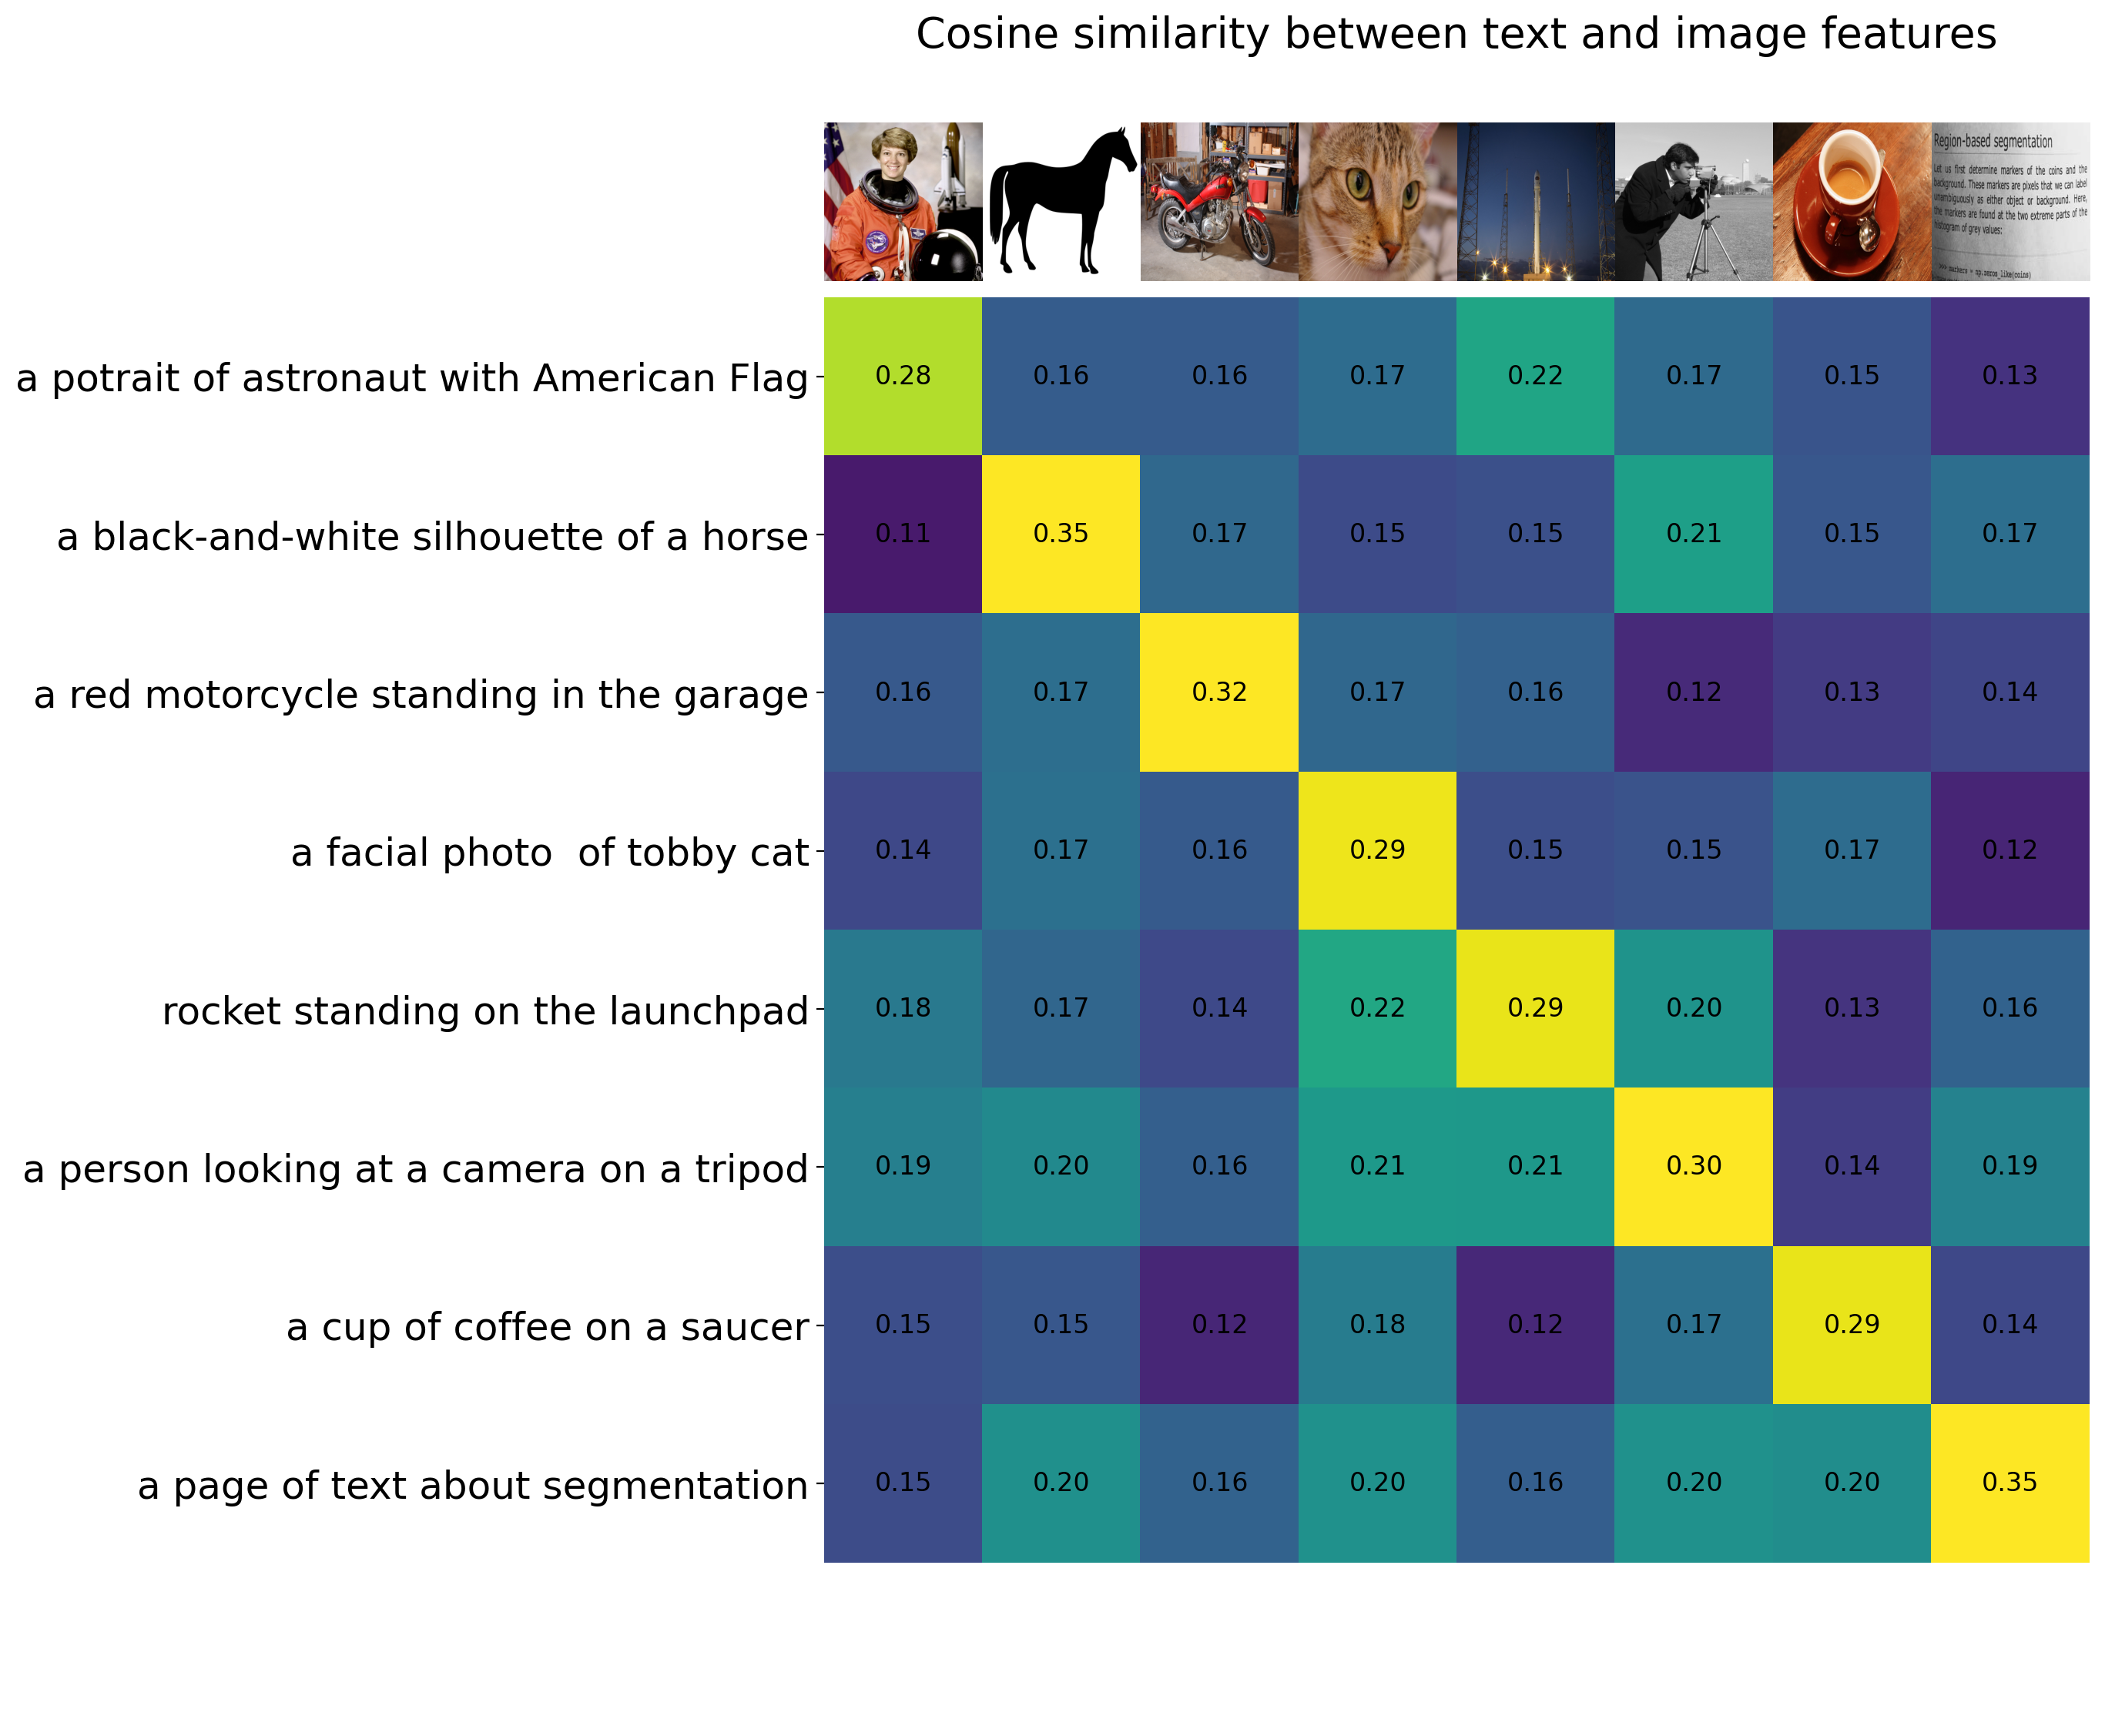

In [16]:
count=len(similarity)

plt.figure(figsize=(20,14))
plt.imshow(similarity,vmin=0.1,vmax=0.3)

plt.yticks(range(count),texts,fontsize=18)
plt.xticks([])

for i,image in enumerate(original_images):
    plt.imshow(image,extent=(i-0.5,i+0.5,-1.6,-0.6),origin="lower")

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x,y,f"{similarity[y,x]:.2f}",ha="center",va="center",size=12)


for side in ["left","top","right","bottom"]:
    plt.gca().spines[side].set_visible(False)


plt.xlim([-0.5,count-0.5])
plt.ylim([count+0.5,-2])

plt.title("Cosine similarity between text and image features",size=20)


# Zero-Shot Image Classification

you can classify images using the cosine similarity(times 100) as the logits to the softmax operation

In [17]:
from torchvision.datasets import CIFAR100

cifar100=CIFAR100(os.path.expanduser("~/.cache"),transform=preprocess,download=True)

100%|██████████| 169001437/169001437 [00:29<00:00, 5649784.58it/s] 


Extracting /home/adi_techbuddy/.cache/cifar-100-python.tar.gz to /home/adi_techbuddy/.cache


In [19]:
print(cifar100.classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [18]:
text_description=[f'This is a photo of a {label}' for label in cifar100.classes ]
text_tokens=clip.tokenize(text_description).cuda()

In [20]:
print(text_tokens.shape)

torch.Size([100, 77])


In [21]:
with torch.no_grad():
    text_features=model.encode_text(text_tokens).float() #(100,512)
    text_features/=text_features.norm(dim=-1,keepdim=True)

text_probs=(100.0*image_features@text_features.T).softmax(dim=-1)  #using the image_feature of those 8 images and checking for given 100 labels
top_probs,top_labels=text_probs.cpu().topk(5,dim=-1)

In [23]:
print(text_probs.shape) #(8 images and 100 possible classes)
print(top_probs.shape)

torch.Size([8, 100])
torch.Size([8, 5])


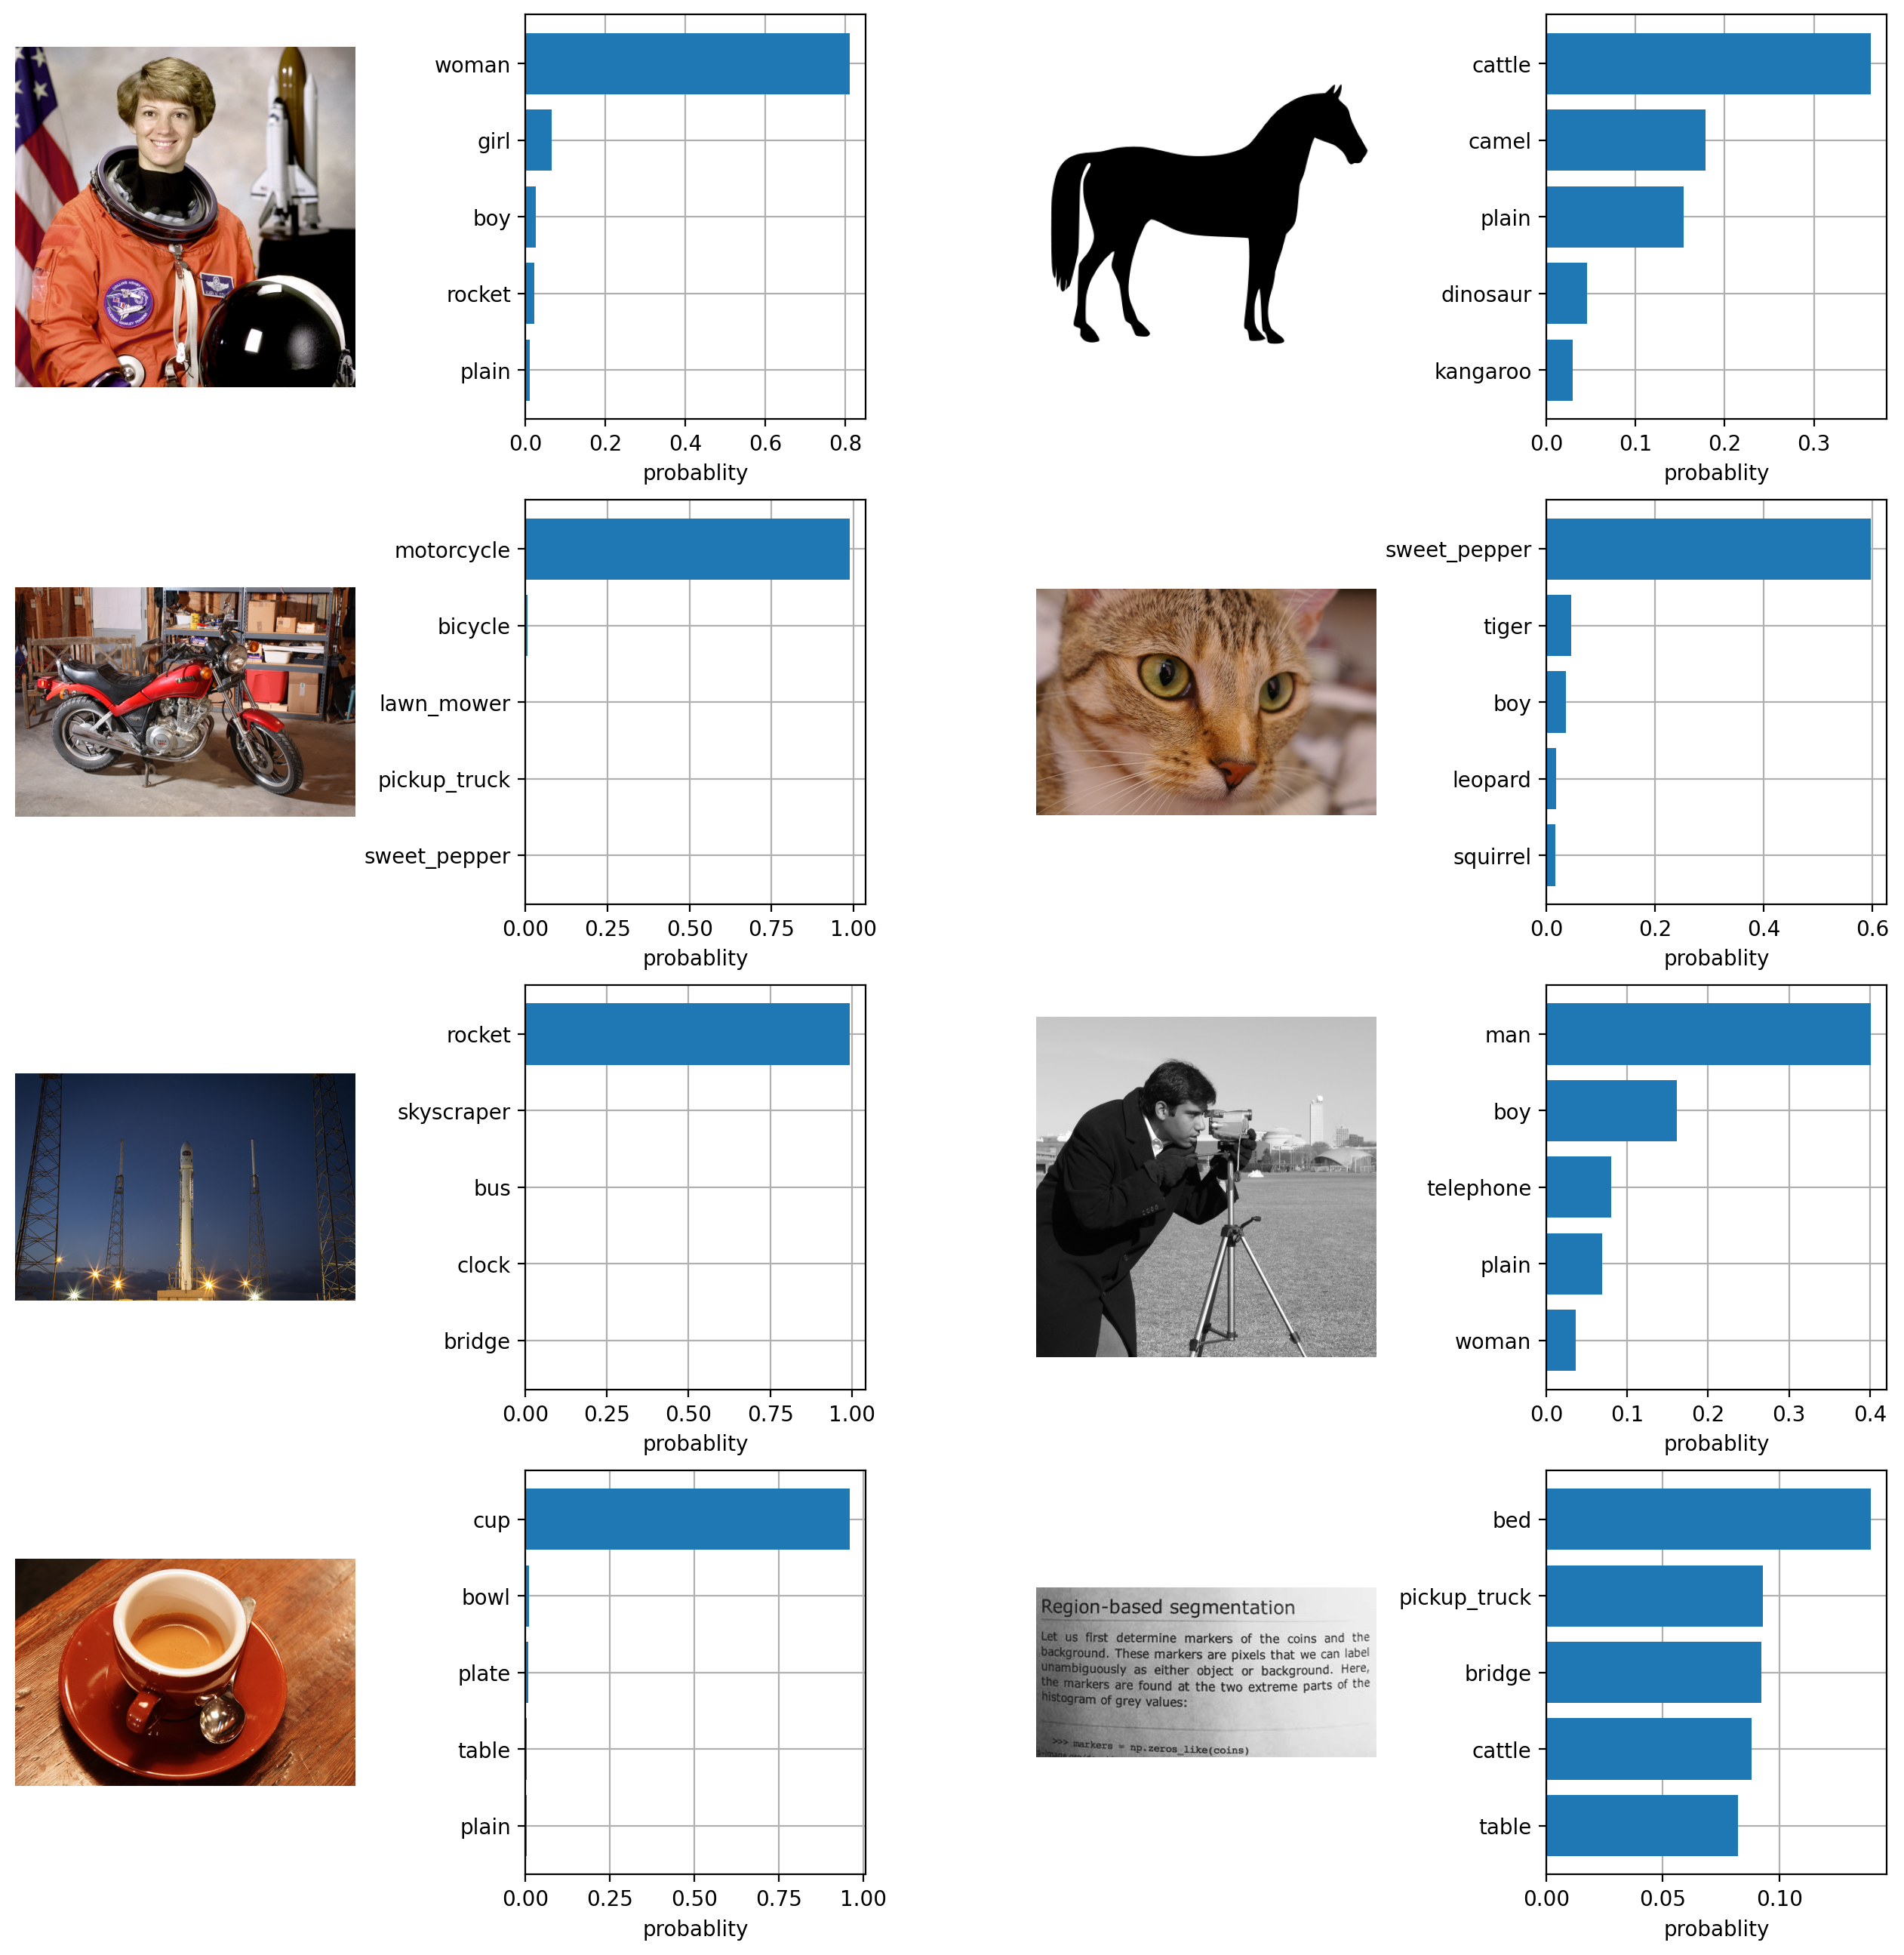

In [27]:
plt.figure(figsize=(16,16))

for i,image in enumerate(original_images):
    plt.subplot(4,4,2*i+1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4,4,2*i+2)
    y=np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y,top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y,[cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probablity")


plt.subplots_adjust(wspace=0.5)
plt.show()